In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
import torch
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score


In [2]:
!pip install transformers accelerate peft datasets


Loading Snapp Food Data Set

In [3]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("ParsiAI/snappfood-sentiment-analysis")

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/8.93M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52110 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8337 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9033 [00:00<?, ? examples/s]

In [7]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `snapp` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cac

In [9]:
# Load the dataset using the datasets library
ds = load_dataset("ParsiAI/snappfood-sentiment-analysis")

# Convert the train split to a pandas DataFrame
df = ds["train"].to_pandas()

In [10]:
print("Train dataset sample:")
print(df.head())

Train dataset sample:
                                             comment  label  label_id
0   غذا خیلی سرد بود در صورتیکه فاصله ما خیلی کم است    SAD       1.0
1     بهتره بتونیم ران یا سینه رو خودمون انتخاب کنیم  HAPPY       0.0
2  غذا بد بود حالم خیییییلی بده. دل دردو دل پیچه....    SAD       1.0
3  با سلام سابق بر این بسته بندی از کیفیت بهتری ب...    SAD       1.0
4                          سلام، خیلی ممنون و متشکرم  HAPPY       0.0


In [ ]:
!huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add t

Frequency of Data Set Classes

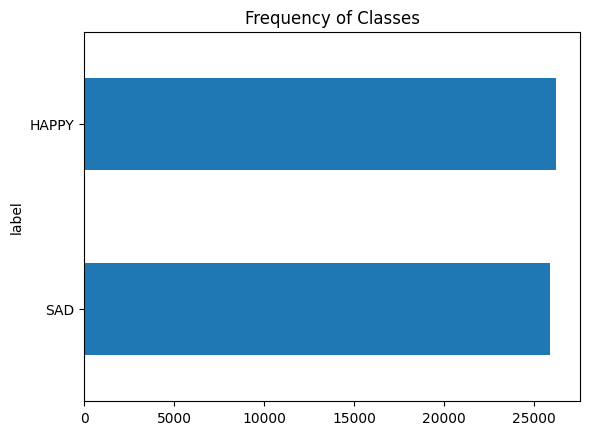

In [11]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Max Length of Comments

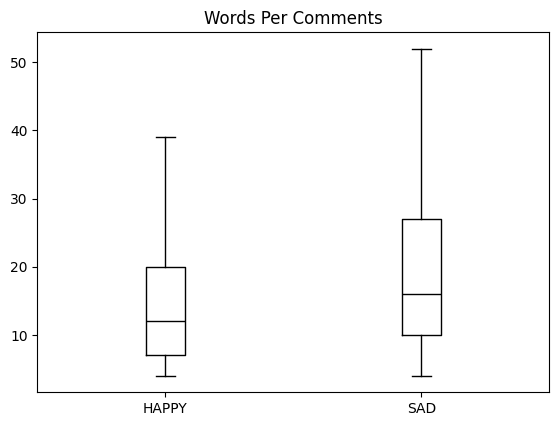

In [14]:
df["Words Per Comments"]=df['comment'].str.split().str.len()
df.boxplot("Words Per Comments", by="label", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Tokenizer

In [15]:
model_name = "sharif-dal/dal-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

In [17]:
# Map string labels to integers
label2id = {"HAPPY": 0, "SAD": 1}

def preprocess_function(examples):
    # Map labels to integers using label2id
    examples["labels"] = [label2id[ex] for ex in examples["label"]]

    # Tokenize the comments
    tokenized = tokenizer(
        examples["comment"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

    # Add labels to tokenized output
    tokenized["labels"] = examples["labels"]
    return tokenized

# Apply preprocessing
encoded_ds = ds.map(preprocess_function, batched=True, batch_size=None)

# Set format for PyTorch
encoded_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/52110 [00:00<?, ? examples/s]

Map:   0%|          | 0/8337 [00:00<?, ? examples/s]

Map:   0%|          | 0/9033 [00:00<?, ? examples/s]

Model

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Positive, negative, mixed
    dtype= "auto",
    device_map="auto"            # Auto-map to GPU
)

# Resize token embeddings if pad_token was added
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sharif-dal/dal-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("sharif-dal/dal-bert", num_labels=3)
for name, module in model.named_modules():
    print(name)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at ai-forever/mGPT-1.3B-persian and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



transformer
transformer.wte
transformer.wpe
transformer.drop
transformer.h
transformer.h.0
transformer.h.0.ln_1
transformer.h.0.attn
transformer.h.0.attn.c_attn
transformer.h.0.attn.c_proj
transformer.h.0.attn.attn_dropout
transformer.h.0.attn.resid_dropout
transformer.h.0.ln_2
transformer.h.0.mlp
transformer.h.0.mlp.c_fc
transformer.h.0.mlp.c_proj
transformer.h.0.mlp.act
transformer.h.0.mlp.dropout
transformer.h.1
transformer.h.1.ln_1
transformer.h.1.attn
transformer.h.1.attn.c_attn
transformer.h.1.attn.c_proj
transformer.h.1.attn.attn_dropout
transformer.h.1.attn.resid_dropout
transformer.h.1.ln_2
transformer.h.1.mlp
transformer.h.1.mlp.c_fc
transformer.h.1.mlp.c_proj
transformer.h.1.mlp.act
transformer.h.1.mlp.dropout
transformer.h.2
transformer.h.2.ln_1
transformer.h.2.attn
transformer.h.2.attn.c_attn
transformer.h.2.attn.c_proj
transformer.h.2.attn.attn_dropout
transformer.h.2.attn.resid_dropout
transformer.h.2.ln_2
transformer.h.2.mlp
transformer.h.2.mlp.c_fc
transformer.h.2.mlp

In [ ]:
model.unload()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): PeftModelForSequenceClassification(
      (base_model): LoraModel(
        (model): GPT2ForSequenceClassification(
          (transformer): GPT2Model(
            (wte): Embedding(100000, 2048)
            (wpe): Embedding(2048, 2048)
            (drop): Dropout(p=0.1, inplace=False)
            (h): ModuleList(
              (0-23): 24 x GPT2Block(
                (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
                (attn): GPT2Attention(
                  (c_attn): Conv1D(nf=6144, nx=2048)
                  (c_proj): Conv1D(nf=2048, nx=2048)
                  (attn_dropout): Dropout(p=0.1, inplace=False)
                  (resid_dropout): Dropout(p=0.1, inplace=False)
                )
                (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
                (mlp): GPT2MLP(
                  (c_fc): Conv1D(nf=8192, nx=2048)
                  (c_proj): Conv1D(nf=2

LoRa Config

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["attn.c_attn", "attn.c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    fan_in_fan_out=True
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 2,365,440 || all params: 1,419,968,512 || trainable%: 0.1666


Traning Parameters

In [21]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=100,
    save_total_limit=2,
    report_to="none"
)

In [22]:
model_name = "sharif-dal/dal-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Compute Metrics

In [23]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.299900,0.284121,0.881372,0.881124
2,0.252600,0.289579,0.881732,0.881571


TrainOutput(global_step=1630, training_loss=0.2847833560288318, metrics={'train_runtime': 703.1975, 'train_samples_per_second': 148.209, 'train_steps_per_second': 2.318, 'total_flos': 6855358547404800.0, 'train_loss': 0.2847833560288318, 'epoch': 2.0})

In [25]:
test_texts = [
    "غذا عالی بود",  # Positive
    "غذا افتضاح بود",  # Negative
    "غذا خوشمزه بود ولی دیر رسید", # Mixed
    "غذا دیر رسید" # Mixed
]

# Create a dictionary to map label IDs back to string labels
id2label = {id: label for label, id in label2id.items()}

for text in test_texts:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to("cuda")
    outputs = model(**inputs)
    print(f"Text: {text}, Predicted: {id2label[outputs.logits.argmax(-1).item()]}")

Text: غذا عالی بود, Predicted: HAPPY
Text: غذا افتضاح بود, Predicted: SAD
Text: غذا خوشمزه بود ولی دیر رسید, Predicted: HAPPY
Text: غذا دیر رسید, Predicted: HAPPY
